In [14]:
import os

In [15]:
os.getcwd()

'/content'

In [16]:
# Imports
from google.colab import drive
drive.mount('/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm


Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [17]:
pd.set_option('display.max_columns', None)

In [18]:
df = pd.read_csv('../drive/MyDrive/data/Basketball/four_factors.csv')

In [19]:
df.shape

(687, 29)

In [20]:
df.head(3)

,TEAM_ID,TEAM_NAME,GP,W,L,W_PCT,MIN,EFG_PCT,FTA_RATE,TM_TOV_PCT,OREB_PCT,OPP_EFG_PCT,OPP_FTA_RATE,OPP_TOV_PCT,OPP_OREB_PCT,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,EFG_PCT_RANK,FTA_RATE_RANK,TM_TOV_PCT_RANK,OREB_PCT_RANK,OPP_EFG_PCT_RANK,OPP_FTA_RATE_RANK,OPP_TOV_PCT_RANK,OPP_OREB_PCT_RANK,season
0,1610612737,Atlanta Hawks,82,33,49,0.402,3956.0,0.471,0.294,0.166,0.297,0.495,0.293,0.161,0.311,1,22,22,22,20,18,13,25,22,28,14,11,9,2002
1,1610612738,Boston Celtics,82,49,33,0.598,3966.0,0.476,0.291,0.144,0.272,0.464,0.318,0.173,0.305,1,8,8,8,8,15,14,5,29,6,24,2,5,2002
2,1610612766,Charlotte Hornets,82,44,38,0.537,3951.0,0.466,0.320,0.154,0.333,0.465,0.294,0.152,0.311,1,11,11,11,24,20,6,10,9,7,15,18,8,2002


# Predictive Analysis
We used this dataset earlier to perform an inference problem in which we try to understand the associations between certain factor variables and wins (or win percentage). We estimated a linear regression model and examined the estimated parameters, residuals, assumptions, etc.

In this notebook, we will use the same dataset to perform a predictive analysis in which we use these same factor variables to predict (aka forecast) the win percentage **in the future**.

Because this data is only at the season level (and not at the schedule level), we **cannot** look at a given part of a season and give a say on what will happen by the end. However, we can look at past seasons and try to forecast what will happen in future seasons! Admittedly, there will be some correlation from year to year, but we won't worry about that now.





## How do we modify the data to fit our new objective?
One way to do it is to simply take the targets of a given season and make them targets of the prior season. This way, each individual row will have season level information about season $x$ trying to predict the target of season $x+1$.

In [21]:
df['season'].max(), df['season'].min()

(2024, 2002)

Note that from 2002 to 2021, some teams have moved and changed names, so we will first need to deal with this issue.

- New Jersey Nets -> Brooklyn Nets
- Charlotte Hornets (1988-2002) -> Charlotte Bobcats (2004-2014) -> Charlotte Hornets (2014-Present)
- New Orleans/Oklahoma City Hornets (2002-2013) -> New Orleans Pelicans (2013-Present)
- Seattle SuperSonics -> Oklahoma City Thunder
- LA Clippers -> Los Angeles Clippers

Change all names to latest version of the team

In [22]:
df['TEAM_NAME'].unique(), df['TEAM_NAME'].nunique()

(array(['Atlanta Hawks', 'Boston Celtics', 'Charlotte Hornets',
        'Chicago Bulls', 'Cleveland Cavaliers', 'Dallas Mavericks',
        'Denver Nuggets', 'Detroit Pistons', 'Golden State Warriors',
        'Houston Rockets', 'Indiana Pacers', 'Los Angeles Clippers',
        'Los Angeles Lakers', 'Memphis Grizzlies', 'Miami Heat',
        'Milwaukee Bucks', 'Minnesota Timberwolves', 'New Jersey Nets',
        'New York Knicks', 'Orlando Magic', 'Philadelphia 76ers',
        'Phoenix Suns', 'Portland Trail Blazers', 'Sacramento Kings',
        'San Antonio Spurs', 'Seattle SuperSonics', 'Toronto Raptors',
        'Utah Jazz', 'Washington Wizards', 'New Orleans Hornets',
        'Charlotte Bobcats', 'New Orleans/Oklahoma City Hornets',
        'Oklahoma City Thunder', 'Brooklyn Nets', 'New Orleans Pelicans',
        'LA Clippers'], dtype=object),
 36)

In [23]:
df.loc[df['TEAM_NAME']=='New Jersey Nets', 'TEAM_NAME'] = 'Brooklyn Nets'
df.loc[df['TEAM_NAME']=='Charlotte Bobcats', 'TEAM_NAME'] = 'Charlotte Hornets'
df.loc[df['TEAM_NAME'].isin(['New Orleans/Oklahoma City Hornets','New Orleans Hornets']), 'TEAM_NAME'] = 'New Orleans Pelicans'
df.loc[df['TEAM_NAME']=='Seattle SuperSonics', 'TEAM_NAME'] = 'Oklahoma City Thunder'
df.loc[df['TEAM_NAME']=='LA Clippers', 'TEAM_NAME'] = 'Los Angeles Clippers'

In [24]:
df['TEAM_NAME'].unique(), df['TEAM_NAME'].nunique()

(array(['Atlanta Hawks', 'Boston Celtics', 'Charlotte Hornets',
        'Chicago Bulls', 'Cleveland Cavaliers', 'Dallas Mavericks',
        'Denver Nuggets', 'Detroit Pistons', 'Golden State Warriors',
        'Houston Rockets', 'Indiana Pacers', 'Los Angeles Clippers',
        'Los Angeles Lakers', 'Memphis Grizzlies', 'Miami Heat',
        'Milwaukee Bucks', 'Minnesota Timberwolves', 'Brooklyn Nets',
        'New York Knicks', 'Orlando Magic', 'Philadelphia 76ers',
        'Phoenix Suns', 'Portland Trail Blazers', 'Sacramento Kings',
        'San Antonio Spurs', 'Oklahoma City Thunder', 'Toronto Raptors',
        'Utah Jazz', 'Washington Wizards', 'New Orleans Pelicans'],
       dtype=object),
 30)

In [25]:
# Sort by team and season
df.sort_values(['TEAM_NAME', 'season'], ascending=False, inplace=True)

# Create Target
df['W_PCT_next_season'] = df.groupby('TEAM_NAME')['W_PCT'].shift(1)

In [26]:
df[['TEAM_NAME', 'season','W','W_PCT','W_PCT_next_season']].head()

,TEAM_NAME,season,W,W_PCT,W_PCT_next_season
686,Washington Wizards,2024,15,0.183,NaN
656,Washington Wizards,2023,35,0.427,0.183
626,Washington Wizards,2022,35,0.427,0.427
596,Washington Wizards,2021,34,0.472,0.427
566,Washington Wizards,2020,25,0.347,0.472


In [27]:
df[['TEAM_NAME', 'season','W','W_PCT','W_PCT_next_season']].tail()

,TEAM_NAME,season,W,W_PCT,W_PCT_next_season
117,Atlanta Hawks,2006,26,0.317,0.366
87,Atlanta Hawks,2005,13,0.159,0.317
58,Atlanta Hawks,2004,28,0.341,0.159
29,Atlanta Hawks,2003,35,0.427,0.341
0,Atlanta Hawks,2002,33,0.402,0.427


As we can see above, the `W_PCT_next_season` is the win percentage for the given team of the *next* season.

## Feature Engineering
Let's create the same predictors that we used in our retrospective analysis.

In [28]:
# Select factors
offensive_factors = ['EFG_PCT','FTA_RATE','TM_TOV_PCT','OREB_PCT']
defensive_factors = ['OPP_EFG_PCT','OPP_FTA_RATE','OPP_TOV_PCT','OPP_OREB_PCT']

# Create model data
df_select = df[['season','TEAM_NAME','W_PCT','W_PCT_next_season']+offensive_factors+defensive_factors].copy()

# Find differences
df_select['EFG_PCT_d'] = df_select['EFG_PCT']-df_select['OPP_EFG_PCT']
df_select['FTA_RATE_d'] = df_select['FTA_RATE']-df_select['OPP_FTA_RATE']
df_select['TM_TOV_PCT_d'] = df_select['TM_TOV_PCT']-df_select['OPP_TOV_PCT']
df_select['OREB_PCT_d'] = df_select['OREB_PCT']-df_select['OPP_OREB_PCT']

# Drop unwanted columns
df_select = df_select.drop(['EFG_PCT','OPP_EFG_PCT','FTA_RATE','OPP_FTA_RATE',
                      'TM_TOV_PCT','OPP_TOV_PCT', 'OREB_PCT','OPP_OREB_PCT'],axis=1)

In [29]:
df_select.head()

,season,TEAM_NAME,W_PCT,W_PCT_next_season,EFG_PCT_d,FTA_RATE_d,TM_TOV_PCT_d,OREB_PCT_d
686,2024,Washington Wizards,0.183,NaN,-0.024,-0.037,0.000,-0.077
656,2023,Washington Wizards,0.427,0.183,0.010,0.014,0.019,-0.003
626,2022,Washington Wizards,0.427,0.427,0.003,0.001,0.013,-0.022
596,2021,Washington Wizards,0.472,0.427,-0.008,0.011,-0.002,-0.014
566,2020,Washington Wizards,0.347,0.472,-0.035,-0.027,-0.020,-0.026


## Modeling Workflow
Since we're performing a predictive analysis, we should take care to follow best practices within the modeling workflow (a small part in the larger data science workflow).

This will include:
- Splitting the data to create training and testing sets
- Saving a portion of the data to make actual predictions (for which we don't know the answer, at least not from looking at this dataset).
- Ensuring there is no data leakage
- Ensuring we will have all necessary information to actually make predictions in the future
- Measure the prediction error across a variety of dimensions
- Propose improvements

### Split the Data
Since this data consists of information from 2002 to 2024. Note that the `season` values correspond to the year in which the NBA season ended (the season spans October to June).
- Training Data: Seasons ending in 2002 to 2022
  - We will use this set of data to build our model(s)
- Testing Data: Season ending in 2023
  - We will use this set of data to evaluate our model(s)
- Production Data: Season ending in 2024
  - We will use this data to make forecasts about the 2024-2025 NBA season
  - Note: We do not know the actual target values for this data because it is in the future. We will only know this when the regular season ends next year. In real life, we build models, evaluate them, and once they are deemed fit for ``production'', we make predictions on data that we don't yet have labels for.

In [30]:
# Create Model Data
split_conditions = [
    (df_select['season']<=2022),
    (df_select['season']==2023),
    (df_select['season']==2024)
]
split_values = ['train','test','prod']
df_select['split_ind'] = np.select(split_conditions, split_values, default='Unknown')
df_select.head()

,season,TEAM_NAME,W_PCT,W_PCT_next_season,EFG_PCT_d,FTA_RATE_d,TM_TOV_PCT_d,OREB_PCT_d,split_ind
686,2024,Washington Wizards,0.183,NaN,-0.024,-0.037,0.000,-0.077,prod
656,2023,Washington Wizards,0.427,0.183,0.010,0.014,0.019,-0.003,test
626,2022,Washington Wizards,0.427,0.427,0.003,0.001,0.013,-0.022,train
596,2021,Washington Wizards,0.472,0.427,-0.008,0.011,-0.002,-0.014,train
566,2020,Washington Wizards,0.347,0.472,-0.035,-0.027,-0.020,-0.026,train


In [31]:
df_select['split_ind'].value_counts(dropna=False)

,count
split_ind,
train,627
prod,30
test,30


### Create Model(s)
We first create a linear regression model with the differenced four factors as our predictors and next season's win percentage as our target.

In [32]:
features = ['EFG_PCT_d','FTA_RATE_d','TM_TOV_PCT_d','OREB_PCT_d']
target = 'W_PCT_next_season'
df_train = df_select[df_select['split_ind']=='train']
df_test = df_select[df_select['split_ind']=='test']
df_prod = df_select[df_select['split_ind']=='prod']

In [33]:
df_prod.head()

,season,TEAM_NAME,W_PCT,W_PCT_next_season,EFG_PCT_d,FTA_RATE_d,TM_TOV_PCT_d,OREB_PCT_d,split_ind
686,2024,Washington Wizards,0.183,NaN,-0.024,-0.037,0.000,-0.077,prod
685,2024,Utah Jazz,0.378,NaN,-0.028,0.016,0.033,0.042,prod
684,2024,Toronto Raptors,0.305,NaN,-0.031,0.023,0.001,-0.025,prod
683,2024,San Antonio Spurs,0.268,NaN,-0.023,-0.002,0.017,-0.010,prod
682,2024,Sacramento Kings,0.561,NaN,0.001,-0.037,-0.007,0.029,prod


In [34]:
# Design Matrices
X_train = df_train[features]
X_test = df_test[features]
X_prod = df_prod[features]

# Targets - no targets for production data
y_train = df_train[target]
y_test = df_test[target]

### Train Model

In [35]:
# Train a Linear Regression Model

# For statsmodels, need to manually add intercept
X_train_sm = sm.add_constant(X_train)

# Train model
linreg_sm = sm.OLS(y_train, X_train_sm).fit()

# Print output
print(linreg_sm.summary())

                            OLS Regression Results                            
Dep. Variable:      W_PCT_next_season   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     87.33
Date:                Thu, 30 Jan 2025   Prob (F-statistic):           7.14e-59
Time:                        23:39:02   Log-Likelihood:                 445.31
No. Observations:                 627   AIC:                            -880.6
Df Residuals:                     622   BIC:                            -858.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.4999      0.005    104.829   

- The first thing to notice is the R-squared and Adj. R-squared measures. We see that these are noticeably lower now that we're predicting the future and not performing a retrospective analysis. Roughly, our four factor variables explain about 36% of the variation in the next season's win percentage.
  - This is expected, as there are lots of things that can influence how well a team will do the following season:
    - Player signings/trades
    - Coaching changes
    - Team health (due to injuries)
    - etc.
- We can also see, that at least directionally, the estimated coefficients agree with our retrospective model.
- We also see that all are statistically significant.
- This is all good, and if we truly wanted to make inferences about the various relationships here, we would need to check our linear regression assumptions as well.
- However, since our primary objective is prediction rather than explanation, we will not dwell too much on these assumptions.

### Evaluate the trained model on our test data

In [36]:
# Evaluate model on test set

# Follow same training data procedures for the test data
X_test_sm = sm.add_constant(X_test)

y_pred_test = linreg_sm.predict(X_test_sm)

# Might also want to obtain the training predictions
y_pred_train = linreg_sm.predict(X_train_sm)

In [37]:
# Ensure these are the same shape
y_test.shape, y_pred_test.shape, y_train.shape, y_pred_train.shape

((30,), (30,), (627,), (627,))

In [ ]:
def RMSE(labels: np.ndarray, preds: np.ndarray) -> np.float64:
  return np.mean((labels-preds)**2)**.5

def MAE(labels: np.ndarray, preds: np.ndarray) -> np.float64:
  return np.mean(np.abs(labels-preds))

In [ ]:
print(f"Training RMSE: {RMSE(labels=y_train, preds=y_pred_train)*100: .2f}%")
print(f"Testing RMSE: {RMSE(labels=y_test, preds=y_pred_test)*100: .2f}%")

print(f"Training MAE: {MAE(labels=y_train, preds=y_pred_train)*100: .2f}%")
print(f"Testing MAE: {MAE(labels=y_test, preds=y_pred_test)*100: .2f}%")

Training RMSE:  11.89%
Testing RMSE:  13.15%
Training MAE:  9.46%
Testing MAE:  10.95%


In [ ]:
print(f"Off by about {RMSE(labels=y_train, preds=y_pred_train)*82: .2f} games for training data")
print(f"Off by about {RMSE(labels=y_test, preds=y_pred_test)*82: .2f} games for testing data")

print(f"Off by about {MAE(labels=y_train, preds=y_pred_train)*82: .2f} games for training data")
print(f"Off by about {MAE(labels=y_test, preds=y_pred_test)*82: .2f} games for testing data")

Off by about  9.75 games for training data
Off by about  10.78 games for testing data
Off by about  7.75 games for training data
Off by about  8.98 games for testing data


So, on average, our predictions are off by about 11 to 13 percentage points (or between 9-11 wins, on average). This may be more or less meaningful depending on the team and their relative standing to the rest of the league.

If a team is a borderline playoff team, being off by 10-11 wins could have significant consequences.

If a team is already at the bottom of the league, then being off by 10-11 games likely won't put them into playoff contention. However, if a team is trying to get a high draft pick for the following season, we might want to have a better grasp on where the team will fall.

Text(0, 0.5, '2023 Actual Win Percentages')

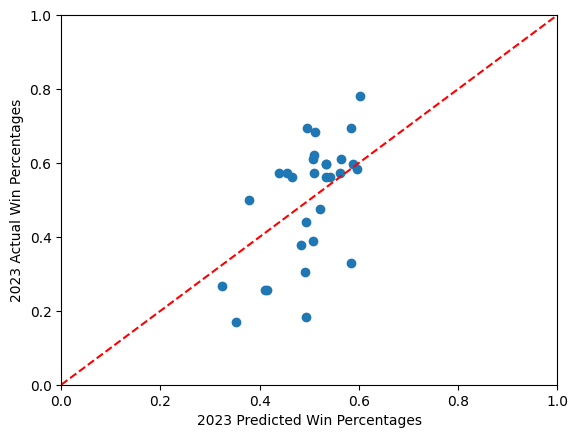

In [ ]:
plt.scatter(y_pred_test, y_test)
plt.xlim([0,1])
plt.ylim([0,1])
plt.axline((0,0), slope=1, color='red', linestyle='dashed')
plt.xlabel('2023 Predicted Win Percentages')
plt.ylabel('2023 Actual Win Percentages')

In [38]:
# Create Deciles
df_y_test = pd.DataFrame({'y_test': y_test,
                          'y_pred_test': y_pred_test,
                          'y_test_bins': pd.qcut(y_test, 10),
                          'y_pred_test_bins': pd.qcut(y_pred_test,10)})

df_y_train = pd.DataFrame({'y_train': y_train,
                          'y_pred_train': y_pred_train,
                          'y_train_bins': pd.qcut(y_train, 10),
                          'y_pred_train_bins': pd.qcut(y_pred_train,10)})


In [39]:
df_y_test.head()

,y_test,y_pred_test,y_test_bins,y_pred_test_bins
656,0.183,0.493053,"(0.17, 0.256]","(0.488, 0.494]"
655,0.378,0.483083,"(0.324, 0.424]","(0.452, 0.488]"
654,0.305,0.490615,"(0.256, 0.324]","(0.488, 0.494]"
653,0.268,0.323128,"(0.256, 0.324]","(0.322, 0.407]"
652,0.561,0.541380,"(0.537, 0.567]","(0.533, 0.561]"


In [40]:
df_y_train.head()

,y_train,y_pred_train,y_train_bins,y_pred_train_bins
626,0.427,0.460193,"(0.415, 0.464]","(0.447, 0.481]"
596,0.427,0.468298,"(0.415, 0.464]","(0.447, 0.481]"
566,0.472,0.400151,"(0.464, 0.512]","(0.377, 0.422]"
536,0.347,0.445160,"(0.293, 0.354]","(0.422, 0.447]"
506,0.390,0.514137,"(0.354, 0.415]","(0.503, 0.524]"


In [41]:
# Perform a Decile Analysis
# 1. For the entire range of actual win percentages, how do our average predictions compare?
# 2. For the entire range of predicted win percentages, how do the actual win percentages compare?

# Group by the bins and compute mean values
df_y_test_actual = df_y_test.groupby('y_test_bins')[['y_test','y_pred_test']].agg('mean').reset_index()
df_y_test_pred = df_y_test.groupby('y_pred_test_bins')[['y_test','y_pred_test']].agg('mean').reset_index()

df_y_train_actual = df_y_train.groupby('y_train_bins')[['y_train','y_pred_train']].agg('mean').reset_index()
df_y_train_pred = df_y_train.groupby('y_pred_train_bins')[['y_train','y_pred_train']].agg('mean').reset_index()


<ipython-input-41-d259a13e1029>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_y_test_actual = df_y_test.groupby('y_test_bins')[['y_test','y_pred_test']].agg('mean').reset_index()
<ipython-input-41-d259a13e1029>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_y_test_pred = df_y_test.groupby('y_pred_test_bins')[['y_test','y_pred_test']].agg('mean').reset_index()
<ipython-input-41-d259a13e1029>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future defaul

In [42]:
df_y_test_actual

,y_test_bins,y_test,y_pred_test
0,"(0.17, 0.256]",0.216500,0.417598
1,"(0.256, 0.324]",0.286500,0.406872
2,"(0.324, 0.424]",0.365667,0.525091
3,"(0.424, 0.537]",0.471667,0.464558
4,"(0.537, 0.567]",0.561000,0.513341
5,"(0.567, 0.573]",0.573000,0.491498
6,"(0.573, 0.598]",0.594750,0.562394
7,"(0.598, 0.61]",0.610000,0.534890
8,"(0.61, 0.684]",0.652500,0.510482
9,"(0.684, 0.78]",0.723333,0.560509


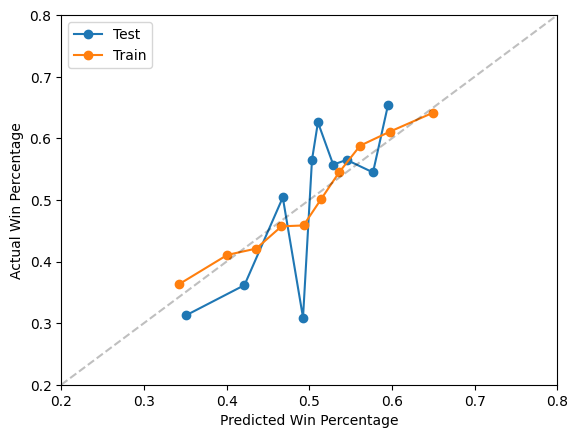

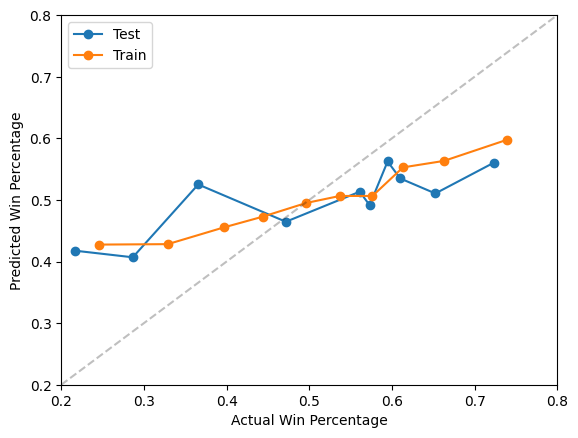

In [ ]:
plt.plot(df_y_test_pred['y_pred_test'], df_y_test_pred['y_test'], label='Test', marker='o')
plt.plot(df_y_train_pred['y_pred_train'], df_y_train_pred['y_train'], label='Train', marker='o')
plt.axline((.3,.3), slope=1, color='black', linestyle='dashed', alpha=.25)
plt.xlim([.2,.8])
plt.ylim([.2,.8])
plt.xlabel('Predicted Win Percentage')
plt.ylabel('Actual Win Percentage')
plt.legend(loc='best')
plt.show();

plt.plot(df_y_test_actual['y_test'], df_y_test_actual['y_pred_test'], label='Test', marker='o')
plt.plot(df_y_train_actual['y_train'], df_y_train_actual['y_pred_train'], label='Train', marker='o')
plt.axline((.3,.3), slope=1, color='black', linestyle='dashed', alpha=.25)
plt.xlim([.2,.8])
plt.ylim([.2,.8])
plt.xlabel('Actual Win Percentage')
plt.ylabel('Predicted Win Percentage')
plt.legend(loc='best')
plt.show();

Both of these plots can show how our model predicts in comparison to actual values for both training and testing sets. If these lines are substantially different, this could indicate overfitting.

- In plot one, we can see how well our model does across the complete range of the predicted win percentages.
  - The training predictions are close to the dashed line indicating that our predictions are well calibrated overall. For example, among teams that our model predicts will win about 60% of their games for the following season, we actually see that those teams tend to actually win about 60% of their games.
  - On the other hand, the test data strays far from the dashed line and far from the training line at certain values. For example, for teams in the 2022-2023 NBA seas that we predicted would win about 50% of their games (i.e., we predict they will be an average team for the season), those teams only ended up winning about 30% of their games. The rest of the test predictions don't seem to be too far off.  

- In the second plot, we can see how well the actual win percentages align with our model predictions across the complete range of actual win percentages.
  - We see that for the most part, our train and test lines are aligned, with the exception of teams that actually won about 35% of their games. For this group we predicted that they would be an above average team.
  - We also see that relative to the $y=x$ line our train and test lines are relatively flat. This suggests that for really poor performing teams, our model predicts them to be better than what they actually are. At the same time, for really good team, our model tends to believe they will be worse than they actually end up being.

### Additional Error Analysis

In [43]:
# Make predictions on production data
X_prod_sm = sm.add_constant(X_prod)
y_pred_prod = linreg_sm.predict(X_prod_sm)

In [44]:
# Attach predictions to original data
df_train_pred = pd.concat([df_train, y_pred_train], axis=1).rename(columns={0:'y_pred_train'})
df_test_pred = pd.concat([df_test, y_pred_test], axis=1).rename(columns={0:'y_pred_test'})
df_prod_pred = pd.concat([df_prod, y_pred_prod], axis=1).rename(columns={0:'y_pred_prod'})

df_select_pred = df_select.merge(
    df_train_pred[['season','TEAM_NAME','y_pred_train']],
    how='left',
    on=['season','TEAM_NAME']
)
df_select_pred = df_select_pred.merge(
    df_test_pred[['season','TEAM_NAME','y_pred_test']],
    how='left',
    on=['season','TEAM_NAME']
)
df_select_pred = df_select_pred.merge(
    df_prod_pred[['season','TEAM_NAME','y_pred_prod']],
    how='left',
    on=['season', 'TEAM_NAME']
)
df_select_pred['y_pred'] = df_select_pred[['y_pred_train','y_pred_test','y_pred_prod']].apply(
    lambda row: row.dropna().values[0], axis=1
)

df_select_pred.drop(['y_pred_train','y_pred_test', 'y_pred_prod'], axis=1, inplace=True)

In [ ]:
df_select_pred.head()

,season,TEAM_NAME,W_PCT,W_PCT_next_season,EFG_PCT_d,FTA_RATE_d,TM_TOV_PCT_d,OREB_PCT_d,split_ind,y_pred
0,2024,Washington Wizards,0.183,NaN,-0.024,-0.037,0.000,-0.077,prod,0.336432
1,2023,Washington Wizards,0.427,0.183,0.010,0.014,0.019,-0.003,test,0.493053
2,2022,Washington Wizards,0.427,0.427,0.003,0.001,0.013,-0.022,train,0.460193
3,2021,Washington Wizards,0.472,0.427,-0.008,0.011,-0.002,-0.014,train,0.468298
4,2020,Washington Wizards,0.347,0.472,-0.035,-0.027,-0.020,-0.026,train,0.400151


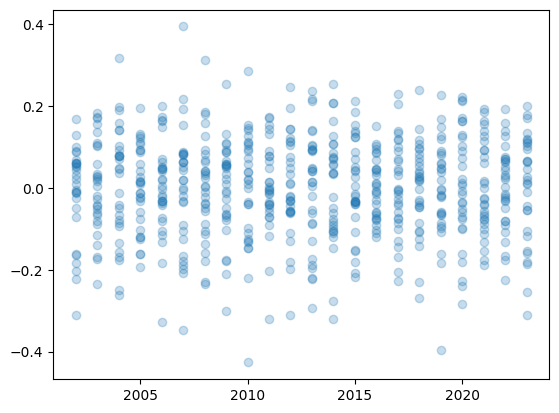

In [45]:
df_select_pred['res'] = df_select_pred['W_PCT_next_season']-df_select_pred['y_pred']
plt.scatter(df_select_pred['season'], df_select_pred['res'], alpha=.25)

- Looks like there's too much going on here to see...

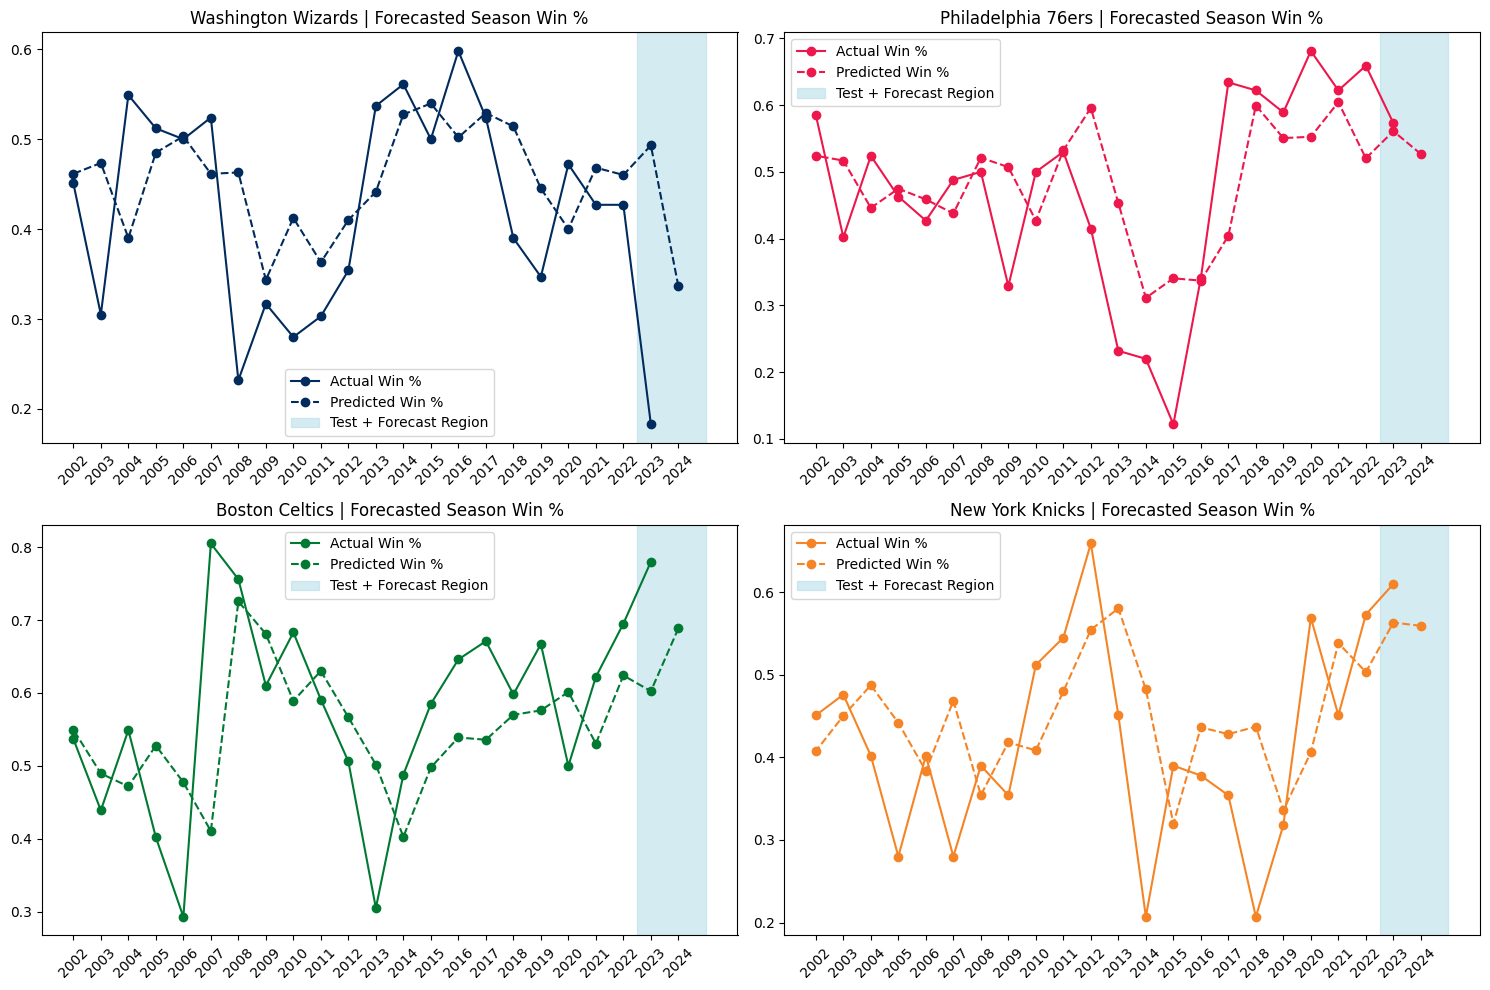

In [46]:
was = df_select_pred[df_select_pred['TEAM_NAME']=='Washington Wizards']
phi = df_select_pred[df_select_pred['TEAM_NAME']=='Philadelphia 76ers']
bos = df_select_pred[df_select_pred['TEAM_NAME']=='Boston Celtics']
nyk = df_select_pred[df_select_pred['TEAM_NAME']=='New York Knicks']
seasons = df_select_pred['season'].unique()
seasons.sort()

fig, axes = plt.subplots(2,2, figsize=(15,10))

axes[0,0].plot(was['season'], was['W_PCT_next_season'], marker='o', label='Actual Win %', color='#002B5C')
axes[0,0].plot(was['season'], was['y_pred'], marker='o', label='Predicted Win %', color='#002B5C', linestyle='dashed')
axes[0,0].axvspan(2022.5, 2025, color='lightblue',alpha=.5, label='Test + Forecast Region')
axes[0,0].set_title('Washington Wizards | Forecasted Season Win %')
axes[0,0].set_xticks(seasons)
axes[0,0].set_xticklabels(seasons, rotation=45)
axes[0,0].legend(loc='best')

axes[0,1].plot(phi['season'], phi['W_PCT_next_season'], marker='o', label='Actual Win %', color='#ED174C')
axes[0,1].plot(phi['season'], phi['y_pred'], marker='o', label='Predicted Win %', color='#ED174C', linestyle='dashed')
axes[0,1].axvspan(2022.5, 2025, color='lightblue',alpha=.5, label='Test + Forecast Region')
axes[0,1].set_title('Philadelphia 76ers | Forecasted Season Win %')
axes[0,1].set_xticks(seasons)
axes[0,1].set_xticklabels(seasons, rotation=45)
axes[0,1].legend(loc='best')

axes[1,0].plot(bos['season'], bos['W_PCT_next_season'], marker='o', label='Actual Win %', color='#007A33')
axes[1,0].plot(bos['season'], bos['y_pred'], marker='o', label='Predicted Win %', color='#007A33', linestyle='dashed')
axes[1,0].axvspan(2022.5, 2025, color='lightblue',alpha=.5, label='Test + Forecast Region')
axes[1,0].set_title('Boston Celtics | Forecasted Season Win %')
axes[1,0].set_xticks(seasons)
axes[1,0].set_xticklabels(seasons, rotation=45)
axes[1,0].legend(loc='best')

axes[1,1].plot(nyk['season'], nyk['W_PCT_next_season'], marker='o', label='Actual Win %', color='#F58426')
axes[1,1].plot(nyk['season'], nyk['y_pred'], marker='o', label='Predicted Win %', color='#F58426', linestyle='dashed')
axes[1,1].axvspan(2022.5, 2025, color='lightblue',alpha=.5, label='Test + Forecast Region')
axes[1,1].set_title('New York Knicks | Forecasted Season Win %')
axes[1,1].set_xticks(seasons)
axes[1,1].set_xticklabels(seasons, rotation=45)
axes[1,1].legend(loc='best')

plt.tight_layout()

Next Season Predictions

In [47]:
df_prod = df_select_pred[df_select_pred['split_ind']=='prod'][['TEAM_NAME','y_pred']].sort_values('y_pred',ascending=False)
df_prod['rank'] = df_prod['y_pred'].rank(ascending=False).astype('int')
df_prod

,TEAM_NAME,y_pred,rank
641,Boston Celtics,0.688582,1
275,Minnesota Timberwolves,0.637377,2
207,Oklahoma City Thunder,0.626380,3
505,Denver Nuggets,0.612162,4
253,New Orleans Pelicans,0.583761,5
298,Milwaukee Bucks,0.563406,6
459,Golden State Warriors,0.562350,7
138,Phoenix Suns,0.560623,8
230,New York Knicks,0.559326,9
551,Cleveland Cavaliers,0.558169,10


One observation is to see a "regression toward the mean" behavior with our forecasts. In other words, forecasts will typically be closer to the center than extreme values.

### Is our linear regression model better than a simple benchmark?
Let's test out using the prior season's win percentage as a forecast for the next season's win percentage.

In [ ]:
benchmark_model_preds_train = df_select[df_select['split_ind']=='train']['W_PCT']
benchmark_model_preds_test = df_select[df_select['split_ind']=='test']['W_PCT']


print(f"Train RMSE Benchmark: {RMSE(labels=y_train, preds=benchmark_model_preds_train)*100: .2f}%")
print(f"Train RMSE Model: {RMSE(labels=y_train, preds=y_pred_train)*100: .2f}%")

print(f"Test RMSE Benchmark: {RMSE(labels=y_test, preds=benchmark_model_preds_test)*100: .2f}%")
print(f"Test RMSE Model: {RMSE(labels=y_test, preds=y_pred_test)*100: .2f}%")

print(f"Train MAE Benchmark: {MAE(labels=y_train, preds=benchmark_model_preds_train)*100: .2f}%")
print(f"Train MAE Model: {MAE(labels=y_train, preds=y_pred_train)*100: .2f}%")

print(f"Test MAE Benchmark: {MAE(labels=y_test, preds=benchmark_model_preds_test)*100: .2f}%")
print(f"Test MAE Model: {MAE(labels=y_test, preds=y_pred_test)*100: .2f}%")



Train RMSE Benchmark:  13.31%
Train RMSE Model:  11.89%
Test RMSE Benchmark:  12.81%
Test RMSE Model:  13.15%
Train MAE Benchmark:  10.31%
Train MAE Model:  9.46%
Test MAE Benchmark:  10.32%
Test MAE Model:  10.95%


In [ ]:
benchmark_model_preds_train = df_select[df_select['split_ind']=='train']['W_PCT']
benchmark_model_preds_test = df_select[df_select['split_ind']=='test']['W_PCT']

print(f"Training RMSE Comparison...")
print(f"{RMSE(labels=y_train, preds=benchmark_model_preds_train)*100: .2f}%")
print(f"{RMSE(labels=y_train, preds=y_pred_train)*100: .2f}%")
print(f"\nTesting RMSE Comparison...")
print(f"{RMSE(labels=y_test, preds=benchmark_model_preds_test)*100: .2f}%")
print(f"{RMSE(labels=y_test, preds=y_pred_test)*100: .2f}%")


Training RMSE Comparison...
 13.31%
 11.89%

Testing RMSE Comparison...
 12.81%
 13.15%


- It turns out that while our model does better on the training data, the simple model does better on the test data. There could be multiple explanations for this.
  1. Because our model provides forecasts that get pulled toward the center of the distribution of win percentages, it's likely that it won't be able to match the more extreme values that our simple benchmark model could pick up.
  2. It's possible that our model overfit to the training data a little more than the benchmark model and could perform worse on the test data.
  3. The test data is for each team may not be entirely representative of years past.
  4. There are other factors from season to season that need to be taken into account to get more accurate forecasts.
    - Personnel changes
    - Health changes
    - Etc.

In [ ]:
# Who had the biggest changes in win percentage from 2023 to 2024?
df_2023 = df_select_pred[df_select_pred['season']==2023].copy().sort_values('TEAM_NAME')
df_2023['W_PCT_chng'] = df_2023['W_PCT_next_season']-df_2023['W_PCT']
df_2023['W_PCT_abs_chng'] = np.abs(df_2023['W_PCT_chng'])


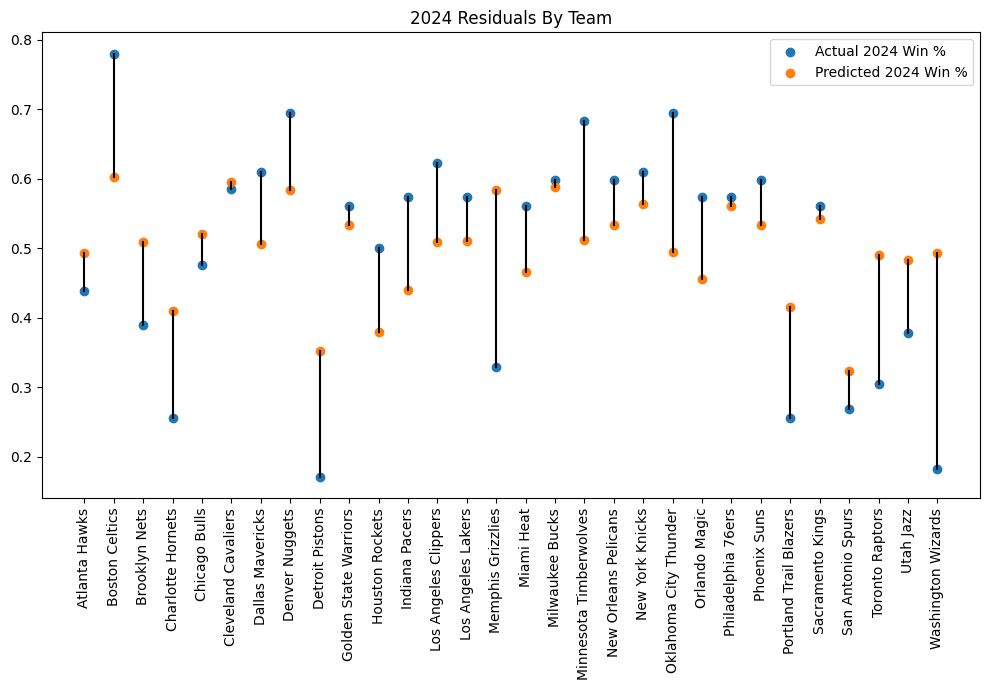

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(df_2023['TEAM_NAME'], df_2023['W_PCT_next_season'], label='Actual 2024 Win %')
plt.scatter(df_2023['TEAM_NAME'], df_2023['y_pred'], label='Predicted 2024 Win %')
for idx, team in enumerate(df_2023['TEAM_NAME']):
  plt.plot([idx,idx], [df_2023['W_PCT_next_season'].iloc[idx], df_2023['y_pred'].iloc[idx]], color='black')

plt.xticks(rotation=90)
plt.title('2024 Residuals By Team')
plt.legend(loc='best')
plt.tight_layout();

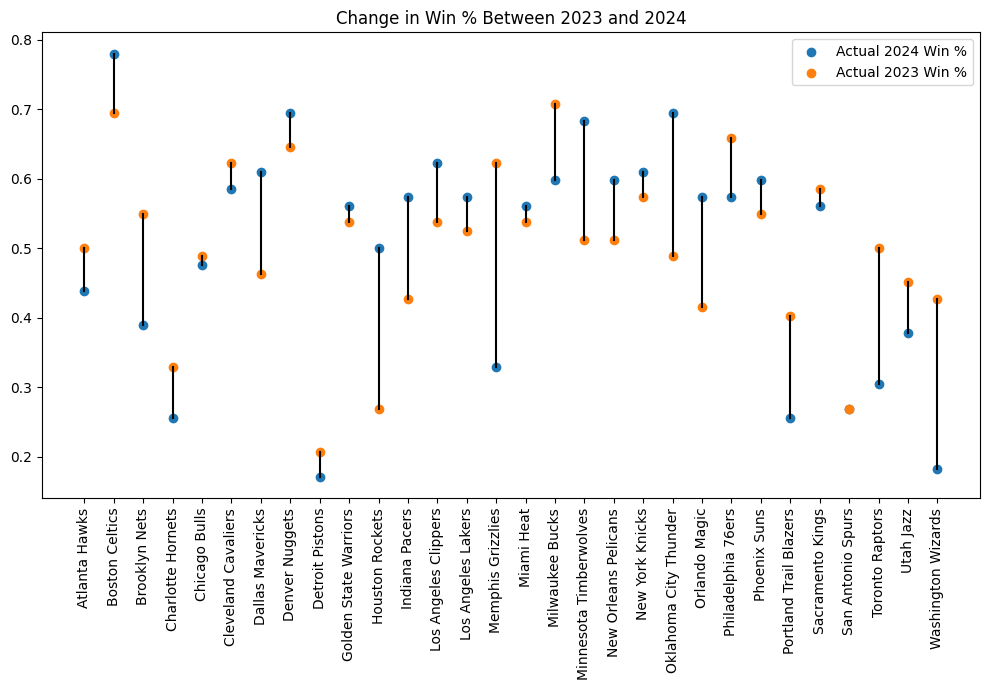

In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(df_2023['TEAM_NAME'], df_2023['W_PCT_next_season'], label='Actual 2024 Win %')
plt.scatter(df_2023['TEAM_NAME'], df_2023['W_PCT'], label='Actual 2023 Win %')
for idx, team in enumerate(df_2023['TEAM_NAME']):
  plt.plot([idx,idx], [df_2023['W_PCT_next_season'].iloc[idx], df_2023['W_PCT'].iloc[idx]], color='black')

plt.xticks(rotation=90)
plt.title('Change in Win % Between 2023 and 2024')
plt.legend(loc='best')
plt.tight_layout();

In [ ]:
df_2023[['TEAM_NAME','W_PCT_abs_chng','W_PCT_chng','W_PCT','W_PCT_next_season','y_pred','res']].sort_values('W_PCT_abs_chng', ascending=False)

,TEAM_NAME,W_PCT_abs_chng,W_PCT_chng,W_PCT,W_PCT_next_season,y_pred,res
345,Memphis Grizzlies,0.293,-0.293,0.622,0.329,0.583870,-0.254870
1,Washington Wizards,0.244,-0.244,0.427,0.183,0.493053,-0.310053
437,Houston Rockets,0.232,0.232,0.268,0.500,0.379381,0.120619
208,Oklahoma City Thunder,0.207,0.207,0.488,0.695,0.494977,0.200023
47,Toronto Raptors,0.195,-0.195,0.500,0.305,0.490615,-0.185615
276,Minnesota Timberwolves,0.171,0.171,0.512,0.683,0.511553,0.171447
619,Brooklyn Nets,0.159,-0.159,0.549,0.390,0.508320,-0.118320
185,Orlando Magic,0.158,0.158,0.415,0.573,0.455467,0.117533
529,Dallas Mavericks,0.147,0.147,0.463,0.610,0.506529,0.103471
116,Portland Trail Blazers,0.146,-0.146,0.402,0.256,0.415653,-0.159653


## For Fun: Fit Tree-Based Model
- For tabular data such as this, usually ensemble tree-based models tend to perform better.
- We will fit two such models here (without doing any real parameter tuning).
  1. Random Forest
  2. CatBoost
- Don't worry if you don't know what these are...

## Random Forest Regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [ ]:
# Instantiate Random Forest Model
rfreg = RandomForestRegressor(random_state=888)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rfreg, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best Model
best_model = grid_search.best_estimator_

# Print the best hyperparameters
print(f"Best parameters found: {grid_search.best_params_}")

# Print the best score (RMSE)
best_rmse = np.sqrt(-grid_search.best_score_)
print(f"Best RMSE: {best_rmse}")

y_train_preds_rf = best_model.predict(X_train)
y_test_preds_rf = best_model.predict(X_test)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best RMSE: 0.12523529220123888


In [ ]:
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_model.feature_importances_
}) \
.sort_values('Importance', ascending=False)

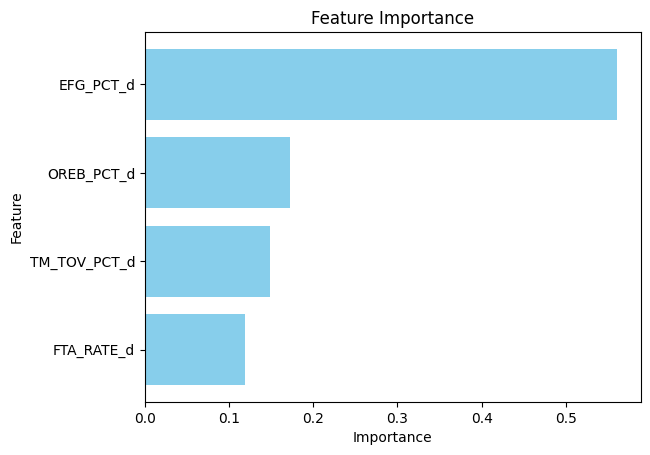

In [ ]:
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()

In [ ]:
print(f"Benchmark Train RMSE: {RMSE(labels=y_train, preds=benchmark_model_preds_train)}")
print(f"Benchmark Train MAE: {MAE(labels=y_train, preds=benchmark_model_preds_train)*100: .2f}%")
print(f"LM Train RMSE: {RMSE(labels=y_train, preds=y_pred_train)}")
print(f"RF Train RMSE: {RMSE(labels=y_train, preds=y_train_preds_rf)}")
print(f"RF Train MAE: {MAE(labels=y_train, preds=y_train_preds_rf)*100: .2f}%")

print(f"Benchmark Test RMSE: {RMSE(labels=y_test, preds=benchmark_model_preds_test)}")
print(f"Benchmark Test MAE: {MAE(labels=y_test, preds=benchmark_model_preds_test)*100: .2f}%")
print(f"LM Test RMSE: {RMSE(labels=y_test, preds=y_pred_test)}")
print(f"RF Test RMSE: {RMSE(labels=y_test, preds=y_test_preds_rf)}")
print(f"RF Test MAE: {MAE(labels=y_test, preds=y_test_preds_rf)*100: .2f}%")

Benchmark Train RMSE: 0.13307296747666766
Benchmark Train MAE:  10.31%
LM Train RMSE: 0.11893676740682642
RF Train RMSE: 0.08732427351393322
RF Train MAE:  6.82%
Benchmark Test RMSE: 0.12811726399409776
Benchmark Test MAE:  10.32%
LM Test RMSE: 0.13147149464514235
RF Test RMSE: 0.13247901574610482
RF Test MAE:  10.53%


- Still can't beat the benchmark!

## CatBoost Regression

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.5 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor

In [ ]:
cbreg = CatBoostRegressor(verbose=0, random_state=888)

# Define the hyperparameters to tune
param_grid = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5]
}

# Perform Grid Search with cross-validation
grid_search_cb = cbreg.grid_search(param_grid, X=X_train, y=y_train, cv=5, plot=True, verbose=0)




MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.2439285383
bestIteration = 99


bestTest = 0.1260997677
bestIteration = 48


bestTest = 0.1247313943
bestIteration = 18


bestTest = 0.2483127848
bestIteration = 99


bestTest = 0.1267742927
bestIteration = 45


bestTest = 0.1269082438
bestIteration = 23


bestTest = 0.2521490074
bestIteration = 99


bestTest = 0.1265806802
bestIteration = 48


bestTest = 0.1280498478
bestIteration = 18


bestTest = 0.1549414357
bestIteration = 199


bestTest = 0.1260997677
bestIteration = 48


bestTest = 0.1247313943
bestIteration = 18


bestTest = 0.1575869436
bestIteration = 199


bestTest = 0.1267742927
bestIteration = 45


bestTest = 0.1269082438
bestIteration = 23


bestTest = 0.1597839906
bestIteration = 199


bestTest = 0.1265806802
bestIteration = 48


bestTest = 0.1280498478
bestIteration = 18


bestTest = 0.1331795865
bestIteration = 299


bestTest = 0.1260997677
bestIteration = 48


bestTest = 0.1247313943
bestIteration = 18


bestTest = 0.1338383845
bestIteration = 299


best

In [ ]:
# Extract the best model
best_model_cb = cbreg

# Use the best model for predictions
y_train_preds_cb = best_model_cb.predict(X_train)
y_test_preds_cb = best_model_cb.predict(X_test)

In [ ]:
print(f"Benchmark Train RMSE: {RMSE(labels=y_train, preds=benchmark_model_preds_train)}")
print(f"LM Train RMSE: {RMSE(labels=y_train, preds=y_pred_train)}")
print(f"RF Train RMSE: {RMSE(labels=y_train, preds=y_train_preds_rf)}")
print(f"CB Train RMSE: {RMSE(labels=y_train, preds=y_train_preds_cb)}")
print(f"CB Train MAE: {MAE(labels=y_train, preds=y_train_preds_cb)*100: .2f}%")

print(f"Benchmark Test RMSE: {RMSE(labels=y_test, preds=benchmark_model_preds_test)}")
print(f"LM Test RMSE: {RMSE(labels=y_test, preds=y_pred_test)}")
print(f"RF Test RMSE: {RMSE(labels=y_test, preds=y_test_preds_rf)}")
print(f"CB Test RMSE: {RMSE(labels=y_test, preds=y_test_preds_cb)}")
print(f"CB Test MAE: {MAE(labels=y_test, preds=y_test_preds_cb)*100: .2f}%")

Benchmark Train RMSE: 0.13307296747666766
LM Train RMSE: 0.11893676740682642
RF Train RMSE: 0.08732427351393322
CB Train RMSE: 0.08792476722703624
CB Train MAE:  6.89%
Benchmark Test RMSE: 0.12811726399409776
LM Test RMSE: 0.13147149464514235
RF Test RMSE: 0.13247901574610482
CB Test RMSE: 0.14848813210098244
CB Test MAE:  11.93%


- Still can't beat the benchmark!